<font size="5">Procesar imagenes ABI y seguir un sistema de nubes en el tiempo. Extraer informaciones globales como Areas de lluvia fuerte y débil</font>

### Tormenta a procesar:
Inicio: 13/03/2023 21 UTC

Fin:    14/03/2023 15 UTC

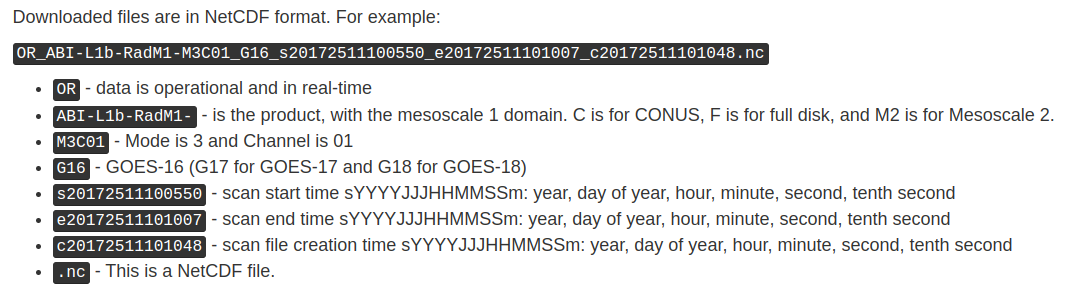

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np

from netCDF4 import Dataset
import cartopy.crs as ccrs  # Plot maps
import os
import sys

from util_imag_2023 import *


# Función de realce lineal al p porciento
def realce(vec, p=2, gamma=1):
    aux = np.sort(vec.flatten())
    imin = int(len(aux) * p / 100)
    imax = int(len(aux) * (100 - p) / 100)
    vmin = float(aux[imin])
    vmax = float(aux[imax])
    rimag = ( (vec - vmin) / (vmax - vmin) )**gamma
    rimag[rimag < 0] = 0
    rimag[rimag > 1] = 1
    return rimag

In [10]:
dir_nc = '/home/msuarez/GOES_16_TF/14032023/CH14/'

Filelist = glob.glob(dir_nc+'*.nc')
Filelist.sort()
Filelist

['/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730000205_e20230730009517_c20230730009565.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730030205_e20230730039514_c20230730039563.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730100205_e20230730109514_c20230730109582.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730130205_e20230730139514_c20230730139574.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730200205_e20230730209514_c20230730209575.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730230205_e20230730239514_c20230730239554.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730300205_e20230730309514_c20230730309568.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14/OR_ABI-L1b-RadF-M6C14_G16_s20230730330205_e20230730339514_c20230730339573.nc',
 '/home/msuarez/GOES_16_TF/14032023/CH14

In [3]:
#img_list_import = [Filelist[5],Filelist[12],Filelist[13],Filelist[16]]

#print('Lista de imagenes a importar:\n')
#for i in range(len(img_list_import)): print(img_list_import[i])

In [4]:
#imagenobj_list = []
#print('Importando imagenes...')
#for i in range(len(img_list_import)): imagenobj_list.append(Dataset(img_list_import[i], 'r'))
#print('Imagenes importadas en la lista imagenobj_list.')

In [5]:
#imagenobj_list[0].variables.keys()

In [3]:
import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')

# Intento primero recortar y despues calibrar las imagenes

In [11]:
imagenobj_list = []
print('Importando imagenes...')
for i in range(len(Filelist)): imagenobj_list.append(Dataset(Filelist[i], 'r'))
print('Imagenes importadas en la lista imagenobj_list.')

metadato_list = [imagenobj_list[i].variables for i in range(len(Filelist))]

# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte
sup_row = 4000
inf_row = 5000
sup_col = 2500
inf_col = 3600

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

imagen_list = []
imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Procesando Canal %d' %icanal)
        #print('pol',pol,' ecu',ecu)
        ####################################################################################################
        imagen = metadato['Rad'][:].data
        print('Tamaño original de la imagen:',imagen.shape)
        print('Recortando imagen')
        # Bandas de 1 km de resolución espacial
        if (icanal == 1) or (icanal == 3) or (icanal == 5):
            print('entra al if 1,3,5')
            imagen = imagen[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        # Bandas de 0.5 km de resolución espacial
        elif icanal == 2:
            print('entra al elif 2')
            imagen = imagen[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        # Bandas de 2 km de resolución espacial
        else:
            print('entra al else')
            imagen = imagen[sup_row:inf_row,sup_col:inf_col]
        ####################################################################################################
        if icanal >7:
            print ('Calibrando la imagen (if)')
            #Parámetros de calibracion
            fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
            fk2 = metadato['planck_fk2'][0] # (=1497.61)
            bc1 = metadato['planck_bc1'][0] # (=0.09102)
            bc2 = metadato['planck_bc2'][0] # (=0.99971)

            imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
            imag_cal_list.append(imag_cal)
            # imag_cal es un array de (5424, 5424)
            Unit = "Temperatura de Brillo [°C]"
        else:
            print ('Calibrando la imagen (else)')
            pendiente= metadato['Rad'].scale_factor
            ordenada= metadato['Rad'].add_offset
            imag_cal =imagen*pendiente+ordenada
            imag_cal_list.append(imag_cal)
            Unit = "Radiancia ["+metadato['Rad'].units+"]"  
    except:
        print('Se ingresó al bloque except!')
        continue
        
    print('\n') 

Importando imagenes...
Imagenes importadas en la lista imagenobj_list.
Tamaño del recorte: Alto= 1000  Ancho= 1100
Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tamaño original de la imagen: (5424, 5424)
Recortando imagen
entra al else
Calibrando la imagen (if)


Procesando Canal 14
Tama

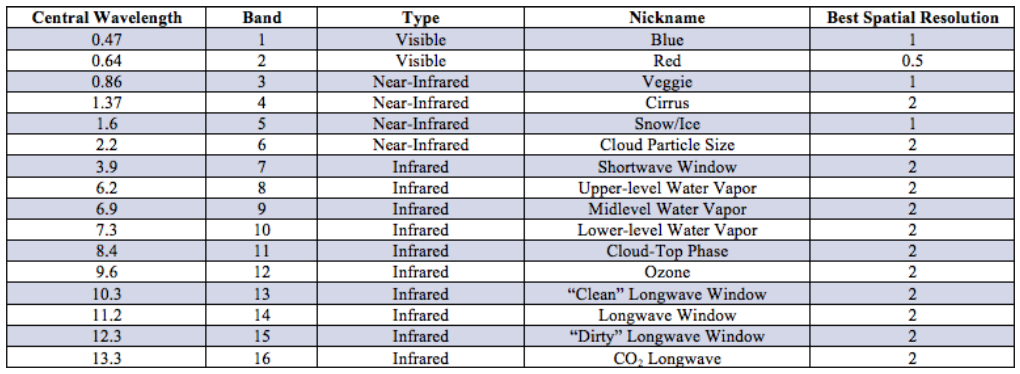

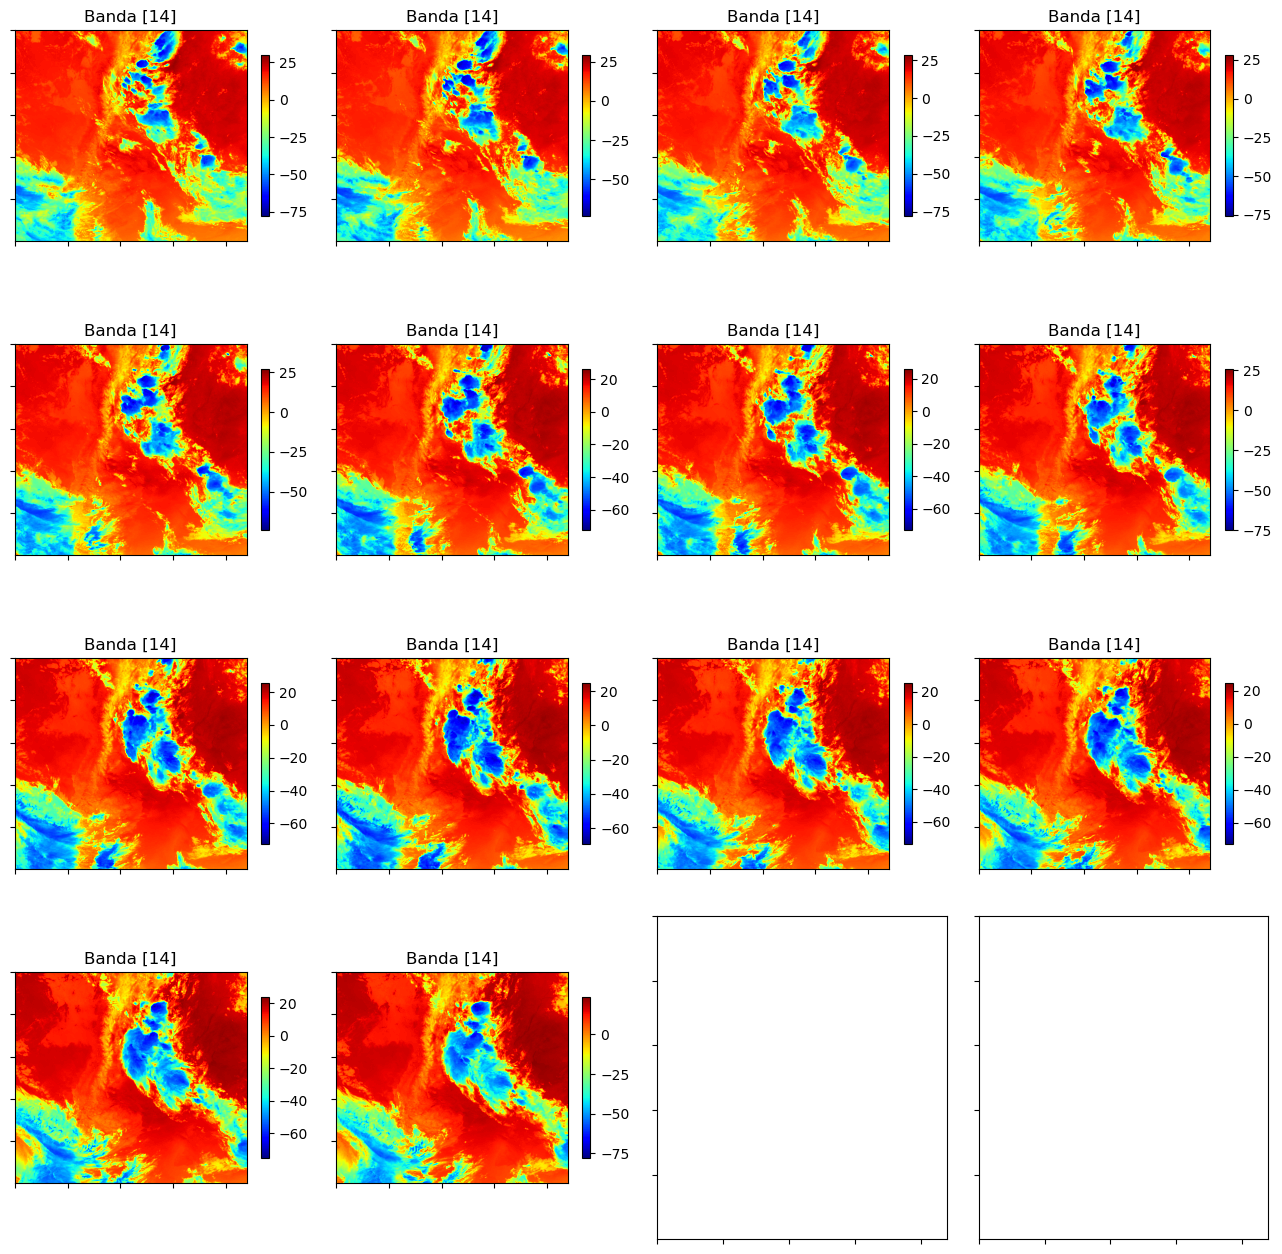

In [12]:
fig, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(13, 13))
ax = ax.ravel()

for i in range(len(imag_cal_list)):
    im = ax[i].imshow(imag_cal_list[i], cmap='jet')
    ax[i].set_title('Banda '+str(metadato_list[i]['band_id'][:]))
    ax[i].set_xticklabels('')
    ax[i].set_yticklabels('')
    fig.colorbar(im, shrink=.5, ax=ax[i])
    
plt.tight_layout()
plt.show()

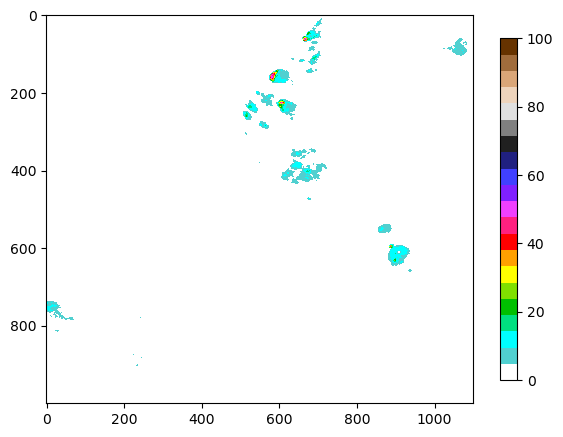

In [13]:
qpe_obj = Dataset('/home/msuarez/GOES_16_TF/14032023/QPE/OR_ABI-L2-RRQPEF-M6_G16_s20230730000205_e20230730009513_c20230730010027.nc', 'r')
 
plt.figure(figsize=(6, 6))

plt.subplot(111)
plt.imshow(qpe_obj.variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap, vmin=0, vmax=100)
plt.colorbar(shrink=.6)

plt.tight_layout()
plt.show()

In [ ]:
metadato_list = [imagenobj_list[i].variables for i in range(len(img_list_import))]

imag_cal_list = []

for metadato in metadato_list:
    
    try:
        # altura de la orbita del satelite en metros (35786023.0)
        altura=metadato['goes_imager_projection'].perspective_point_height
        # 6378137.0 semieje mayor en metros
        semieje_may=metadato['goes_imager_projection'].semi_major_axis
        # 6356752.31414 semieje menor en metros
        semieje_men=metadato['goes_imager_projection'].semi_minor_axis
        # -75 longitud central
        lon_cen=metadato['goes_imager_projection'].longitude_of_projection_origin

        #img_extent = (-5500000, 5500000, -5500000, 5500000) #dimensiones de la escena en km
        img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)
        pol=semieje_may*altura/(semieje_may+altura) # 5413321.583523803
        ecu=semieje_men*altura/(semieje_may+altura) # 5395171.741097588

        icanal = int(metadato['band_id'][:])
        print ('Canal %d' %icanal)
        print('pol',pol,' ecu',ecu)
        print('\n')

        imagen_list.append(metadato['Rad'][:].data)

    except:
        continue

In [12]:
metadato_list[0]['Rad']

<class 'netCDF4._netCDF4.Variable'>
int16 Rad(y, x)
    _FillValue: 1023
    long_name: ABI L1b Radiances
    standard_name: toa_outgoing_radiance_per_unit_wavelength
    _Unsigned: true
    sensor_band_bit_depth: 10
    valid_range: [   0 1022]
    scale_factor: 0.030088475
    add_offset: -0.9609507
    units: W m-2 sr-1 um-1
    resolution: y: 0.000056 rad x: 0.000056 rad
    coordinates: band_id band_wavelength t y x
    grid_mapping: goes_imager_projection
    cell_methods: t: point area: point
    ancillary_variables: DQF
unlimited dimensions: 
current shape = (5424, 5424)
filling on

In [ ]:
imag_cal_list = []
icanal_list = []

num_metadato_list = 0

for imagen in imagen_list:

    metadato = metadato_list[num_metadato_list]
    icanal = int(metadato['band_id'][:])
    print ('Canal %d' %icanal)
    
    icanal_list.append(icanal)

    if icanal >7:
        print ('Calibrando la imagen (if)')
        #Parámetros de calibracion
        fk1 = metadato['planck_fk1'][0] # DN -> K  (=13432.1)
        fk2 = metadato['planck_fk2'][0] # (=1497.61)
        bc1 = metadato['planck_bc1'][0] # (=0.09102)
        bc2 = metadato['planck_bc2'][0] # (=0.99971)

        imag_cal = (fk2 / (np.log((fk1 / imagen) + 1)) - bc1 ) / bc2-273.15 # K -> C
        imag_cal_list.append(imag_cal)
        # imag_cal es un array de (5424, 5424)
        Unit = "Temperatura de Brillo [°C]"
    else:
        print ('Calibrando la imagen (else)')
        pendiente= metadato['Rad'].scale_factor
        ordenada= metadato['Rad'].add_offset
        imag_cal =imagen*pendiente+ordenada
        imag_cal_list.append(imag_cal)
        Unit = "Radiancia ["+metadato['Rad'].units+"]"

    num_metadato_list = num_metadato_list+1

In [ ]:
i = 2

plt.imshow(imag_cal_list[i], cmap='Greys')
plt.show()

In [ ]:
# Recorte en la Argentina basados en las bandas con 2 km de resolución espacial
# Si la banda es de 1 km y 0.5 km de resolución entonces se debe multiplicar estos valores por 2 y 4
# respectivamente, de forma tal de obtener el mismo recorte
sup_row = 4000
inf_row = 5000
sup_col = 2500
inf_col = 3600

print('Tamaño del recorte: Alto=',inf_row-sup_row,' Ancho=',inf_col-sup_col)

plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(imag_cal_list[0][sup_row:inf_row,sup_col:inf_col], cmap='cool')

plt.subplot(132)
plt.imshow(imag_cal_list[1][sup_row:inf_row,sup_col:inf_col], vmin=-90., vmax=40., cmap=cmap)

plt.subplot(133)
plt.imshow(imag_cal_list[2][sup_row:inf_row,sup_col:inf_col], vmin=-90., vmax=40., cmap=cmap)

plt.tight_layout()
plt.show()

In [ ]:
RGB = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))
RGB_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

i = 0
for img in imag_cal_list:
    # Bandas de 1 km de resolución espacial
    if (icanal_list[i] == 1) or (icanal_list[i] == 3) or (icanal_list[i] == 5):
        print('icanal=',icanal_list[i],' entra al if 1,3,5')
        RGB[:,:,i] = img[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
        RGB_realzada[:,:,i] = realce(img[sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2])
    # Bandas de 0.5 km de resolución espacial
    elif icanal_list[i] == 2:
        print('icanal=',icanal_list[i],' entra al if 2')
        RGB[:,:,i] = img[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
        RGB_realzada[:,:,i] = realce(img[sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4])
    # Bandas de 2 km de resolución espacial
    else:
        print('icanal=',icanal_list[i],' entra al else')
        RGB[:,:,i] = img[sup_row:inf_row,sup_col:inf_col]
        RGB_realzada[:,:,i] = realce(img[sup_row:inf_row,sup_col:inf_col])
        
    i=i+1

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.imshow(imag_cal_list[0][sup_row:inf_row,sup_col:inf_col])
plt.colorbar(shrink=.6)

plt.subplot(222)
plt.imshow(imag_cal_list[1][sup_row:inf_row,sup_col:inf_col],
           cmap='jet')
plt.colorbar(shrink=.6)

plt.subplot(223)
plt.imshow(imag_cal_list[2][sup_row:inf_row,sup_col:inf_col],
           cmap='jet')
plt.colorbar(shrink=.6)

plt.subplot(224)
plt.imshow(imagenobj_list[3].variables['RRQPE'][:].data[sup_row:inf_row,sup_col:inf_col],
           cmap=cmap)
plt.colorbar(shrink=.6)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
#proyeccion geoestacionaria para Goes16
crs=ccrs.Geostationary(central_longitude=lon_cen, satellite_height=altura)
ax = plt.axes(projection=crs)
ax.gridlines() #agrega linea de meridianos y paralelos
ax.coastlines(resolution='10m',color='blue') #agrega líneas de costa

img=plt.imshow(imagenobj_list[3].variables['RRQPE'][:].data,
               extent=img_extent,vmin=0,vmax=100,
               cmap=cmap)

# Add a colorbar
plt.colorbar(img,
             label='rainfall_rate (mm h-1)',
             extend='both', orientation='vertical',
             pad=0.05, fraction=0.05)

plt.show()

In [ ]:
#%% Recortes crudos
psize=2000 # lado de pixel de referencia en m
N=5424 #numero de pixeles de referencia

Nx=1000 #numero de puntos del recorte en x
Ny=1000 #numero de puntos del recorte en x

esc=int(imag_cal.shape[0]/N)

x0=-200000 # Coordenada x del limite superior izquierdo en m
y0=-2500000 # Coordenada y del limite superior izquierdo en m

f0=int((img_extent[1]-y0)/psize*esc) #fila del angulo superior izquierdo
c0=int((img_extent[3]+x0)/psize*esc) #columna del angulo superior izquierdo
f1=int(f0+Nx*esc) #fila del angulo inferior derecho
c1=int(c0+Ny*esc) #columna del angulo inferior derecho

img_extentr=[x0,x0+Nx*psize*esc,y0-Ny*psize*esc,y0]

indf=range(f0,f1,esc)
indc=range(c0,c1,esc)
# im_rec=imag_cal[:].data[indf,indc]
im_rec=imagenobj_list[3].variables['RRQPE'][:].data[indf[0]:indf[-1],indc[0]:indc[-1]]

plt.figure()
img=plt.imshow(im_rec,cmap=cmap,vmin=0,vmax=100)
plt.colorbar(img, label='rainfall_rate (mm h-1)', extend='both', orientation='vertical',
             pad=0.05, fraction=0.05)


#%%

# im_rec=imagedata[f0:f1:esc,c0:c1:esc]
plt.figure()
ax = plt.axes(projection=crs)
ax.gridlines() #agrega linea de meridianos y paralelos
ax.coastlines(resolution='10m',color='blue') #agrega líneas de costa

img=plt.imshow(im_rec,transform=crs, extent=img_extentr,cmap=cmap,vmin=0,vmax=100)
plt.colorbar(img, label='rainfall_rate (mm h-1)', extend='both', orientation='vertical',
             pad=0.05, fraction=0.05)

plt.show()

In [74]:
# RGB = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

# RGB[:,:,0] = imag_cal_list[0][sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2]
# RGB[:,:,1] = imag_cal_list[1][sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4]
# RGB[:,:,2] = imag_cal_list[3][sup_row:inf_row,sup_col:inf_col]

In [77]:
# RGB_realzada = np.zeros((inf_row-sup_row, inf_col-sup_col, 3))

# # Aplico realces
# RGB_realzada[:,:,0] = realce(imag_cal_list[0][sup_row*2:inf_row*2,sup_col*2:inf_col*2][::2,::2])
# RGB_realzada[:,:,1] = realce(imag_cal_list[1][sup_row*4:inf_row*4,sup_col*4:inf_col*4][::4,::4])
# RGB_realzada[:,:,2] = realce(imag_cal_list[2][sup_row:inf_row,sup_col:inf_col])

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.imshow(RGB)
plt.title('Imagen RGB')

plt.subplot(122)
plt.imshow(RGB_realzada)
plt.title('Imagen RGB realzada')

plt.tight_layout()
plt.show()